In [1]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [2]:
#对于输入，图片是维度是（1，28，28），对于softmax来说，输入需要转成一维的向量, 1*28*28 = 784
#对于输出因为数据集有10个类别所以网络的输出维度为10
num_inputs = 784
num_outputs = 10
W = torch.normal(0,0.01,size=(num_inputs, num_outputs),requires_grad=True) #size是关键
b = torch.zeros(num_outputs, requires_grad=True)

In [3]:
X = torch.tensor([[1.,2.,3.],[4.,5.,6.]]) #2*3的矩阵
print(X)
X.sum(0,keepdim=True), X.sum(1,keepdim=True)
X.sum(1,keepdim=True).size()
#回顾下矩阵的按行相加， 按列相加， 0的输出是行向量； 1的输出是列向量

tensor([[1., 2., 3.],
        [4., 5., 6.]])


torch.Size([2, 1])

In [4]:
# 实现sotfmax
# 输出是10维的，所以每一个操作子是10维 
# 对于一个数据，有10个概率o需要处理，对于多个矩阵不再是一个数据时候的行向量了， X的size是(num_inputs, num_outputs), 每一行是一个数据
# 所以softmax是对每一行，即一个数据做处理
def softmax(X):
    X_exp = torch.exp(X) #对每个元素操作
    partition = X_exp.sum(1,keepdim=True) #按行相加，每行加到一起, size是（[行数，1]）, keepdim = True 保留的是size(行数,1)
    return X_exp/ partition #这里是广播机制， 对每一行除以对应的行的partition元素

In [5]:
#验证下softmax ， 结果应该是每行的元素都是非负且每行的和为1
X= torch.normal(0,1,(2,5))
X_prob = softmax(X)
X_prob,X_prob.sum(1)

(tensor([[0.2895, 0.0998, 0.0604, 0.0773, 0.4730],
         [0.2015, 0.1641, 0.2374, 0.0695, 0.3274]]),
 tensor([1.0000, 1.0000]))

In [6]:
#实现softmax回归模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W)+b)
    # X.reshape((-1, W.shape[0]) ，-1是不改变 保留批量的大小即256， W.shape[0], 是784
# 模型的输入是数据集X，softmax的输入是 y=wx+b的y, 模型的输出是softmax(y)

In [7]:
#补充个细节,怎么拿具体的y_hat
#创建个数据y_hat, 包含2个样本，在3个类别的预测概率 ，使用y作为y_hat中概率的索引
y = torch.tensor([0,2]) #向量长度2， 第一个元素0，第二个元素2，是真值的标号
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3, 0.2,0.5]]) #预测值
y_hat[[0,1],y] #对第0个样本拿出第0个元素，对第1个样本拿出第2个元素
print(len(y_hat))

2


In [8]:
#实现交叉熵损失函数
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y]) # y是真值标号

In [9]:
#将预测类别于真实y元素进行比较
def accuracy(y_hat, y):
    "计算预测正确的数量"
    if len(y_hat.shape)>1 and y_hat.shape[1] >1: #y_hat是个2维矩阵的话，shape>1, 且列数 y_hat.shape[1]>1
        y_hat = y_hat.argmax(axis=1) # 取每一行元素最大的那个
    cmp = y_hat.type(y.dtype) == y #将y_hat的数据类型转成y的类型
    return float(cmp.type(y.dtype).sum()) #又转成和y一样的类型 求和，得到所有预测正确的样本数量

accuracy(y_hat, y)/len(y)

0.5

In [10]:
#评估任意模型net的准确度
def evaluate_accuracy(net, data_iter):
    "计算在指定数据集上模型的精度"
    if isinstance(net , torch.nn.Module): #判断net的类型是不是torch.nn.module
        net.eval() #将模型设置维评估模式, 即不要计算梯度了 ，只做forward pass
    metric = Accumulator(2) #正确预测数，预测总数, 累加器
    for X,y in data_iter:
        metric.add(accuracy(net(X),y) ,y.numel()) #net(X)得到的是y_hat, y.numel()得到的是样本总数
    return metric[0] /metric[1] #[0]是正确的数， [1]是总数

class Accumulator: #创建两个变量分别存储正确的预测数量和 预测的总数
    "在n个变量上累加"
    def __init__(self,n):
        self.data =[0.0]*n

    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data =[0.0]*len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

evaluate_accuracy(net, test_iter)

0.0484

In [15]:
#训练函数, 对整个数据迭代一次的操作
def train_epoch_ch3(net, train_iter, loss, updater):  
    if isinstance(net,torch.nn.Module):#判断该子类是否属于父类
        net.train() # 将模型设置为训练模式，即要计算梯度
    # 用累加器创建三个实例训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)

    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step() #固定模式
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())#更新累加器
    # 返回训练损失和训练精度 ，[0]是损失的累加 ，[2]是样本总数， [1]是预测正确的数
    return metric[0] / metric[2], metric[1] / metric[2]

In [11]:
#定义一个类，可以看到训练过程中损失和精度的变化情况
def set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator:  #在动画中绘制数据
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [12]:
#最后总的训练函数
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #训练模型
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

In [13]:
#小批量随机梯度下降来优化模型的损失函数
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W,b], lr, batch_size)
    

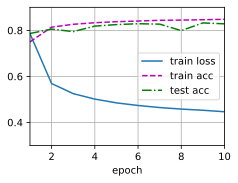

In [16]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

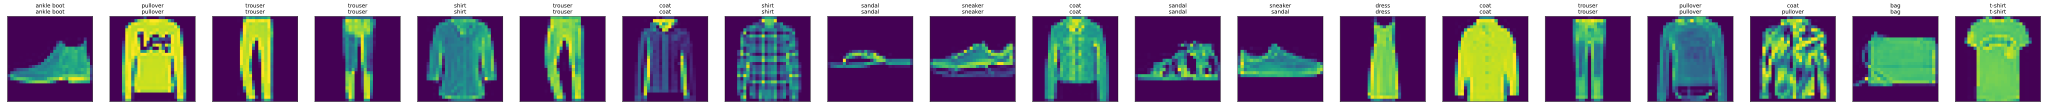

In [21]:
#最后预测下，即调用训练好的模型，看下和测试数据集的结果怎么样
def predict_ch3(net, test_iter, n=20):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)),1,n,titles[0:n],4)

predict_ch3(net, test_iter)